In [2]:
import numpy as np
import numpy.linalg as la
from watermatrices import Amat, Bmat, yvec
import seaborn as sns

# a)

In [3]:
def inf_norm(M): 
    """Computes the max norm of a matrix M"""
    return np.max(np.sum(np.abs(M),axis = 1))
def condition(M): 
    """Returns condition number of a matrix M"""
    return inf_norm(M)*inf_norm(np.linalg.inv(M))

In [4]:
#the frequencies are given by
omega = np.array([0.800, 1.146, 1.400])
#Write matrices E and S
n = np.shape(Amat)[0]
I = np.identity(n)
Zmat = np.zeros((n,n))
E = np.block([[Amat,Bmat],[Bmat,Amat]])
S = np.block([[I,Zmat],[Zmat,-I]])
z = np.concatenate((yvec,-yvec))
CondK = np.empty(shape=(3,)) #array to store solution
#Compute the condition number of E-\omega*S for 3 different frequencies
#and store it in Kmat
Kmat = np.empty(shape=(3,*np.shape(E)))
for i in range(3):
    Kmat[i] = E-omega[i]*S
    CondK[i] = condition(Kmat[i])

## How many digits of the 8 digit solution can we trust

# b)

In [5]:
dw = 1/2*1e-3
Bound = np.empty(shape=(3,))
for i in range(3):
    Bound[i] = CondK[i]*inf_norm(dw*S)/inf_norm(Kmat[i])

# c)

## 1.

In [6]:
def lu_factorize(A):
    """Performs matrix decomposition A=LU where L is lower triangular and 
    U is upper triangular. Returns L and U."""
    n = A.shape[0]
    U = np.zeros((n, n), dtype=np.double)
    L = np.eye(n, dtype=np.double)
    for k in range(n):
        U[k, k:] = A[k, k:] - L[k,:k].dot(U[:k,k:])
        L[(k+1):,k] = (A[(k+1):,k] - L[(k+1):,:].dot(U[:,k]))/ U[k, k]
    return L, U

## 2.

In [7]:
def forward_substitute(L,z):
    """Takes lower triangular matrix L and vector z and return y, such that
    Ly=z."""
    y = np.zeros((len(z),))
    y[0] = z[0]
    for i in np.arange(1,len(y)):
        y[i] = z[i]-L[i,:].dot(y) 
    return y

## 3. 

In [8]:
def back_substitute(U,y):
    """"Takes upper triangular matrix U and vector y and performs back substitution 
    returning x, such that Ux = y."""
    n = len(y)
    x = np.zeros((n,))
    for i in np.arange(n-1,-1,-1):
        x[i] = (y[i]-U[i,:].dot(x))/U[i,i]
    return x

In [9]:
def solve_linear(A,b):
    L,U = lu_factorize(A)
    y = forward_substitute(L,b)
    x = back_substitute(U,y)
    return x

In [10]:
TM = np.array([[2,1,1],[4,1,4],[-6,-5,3]])
b = np.array([4,11,4])
x_custom = solve_linear(TM,b)
x_np = la.solve(TM,b)
x_custom-x_np

array([-3.10862447e-15,  4.44089210e-15,  1.77635684e-15])

## d. 

In [19]:
def solve_alpha(omega):
    x = solve_linear(E-omega*S,z)
    return z,z@x,x

In [12]:
alpha = np.empty(shape=(3))
for i in range(3):
    alpha[i] = solve_alpha(omega[i])

### (1) 

|$\omega$|$\alpha$|
|--------|--------|
|0.800|$1.636\pm0.005$|
|1.146|$2609.2\pm2.5$|
|1.400|$-2.708\pm0.004$|

## e 

In [16]:
omega_vec = np.linspace(1.2,4,1000)
alpha_vec = np.empty(shape=(omega_vec.shape[0]))
for i in range(len(omega_vec)):
    alpha_vec[i] = solve_alpha(omega_vec[i])
alpha_sing = solve_alpha(1.60686978)

<AxesSubplot:>

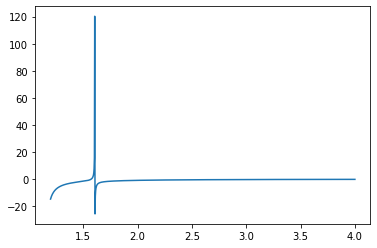

In [14]:
sns.lineplot(omega_vec, alpha_vec)